# Divvy Bikeshare Analysis

Forecast and visualize Divvy Bikeshare ridership

## Import Packages

In [1]:
# import packages and data
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import glob
import warnings
import statsmodels.api as sm
import sklearn.ensemble as ske
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.tools.plotting import autocorrelation_plot
from dateutil.relativedelta import relativedelta
from datetime import datetime as dt
from datetime import timedelta
import plotly 
plotly.tools.set_config_file(world_readable=False,
                             sharing='private')
import pickle
plotly.tools.set_credentials_file(username="anaelisagentle", api_key="B7m9v4maNpmgbQObNZ4U")


warnings.filterwarnings("ignore")
%matplotlib inline

## Create Dataframe

Create a dataframe from csv files of Divvy Bikeshare data. Once data is organized, it is stored in a pickle file for easy loading.

In [2]:
def open_files(folder):
    """
    ===============================
    This function creates a dataframe from multiple csv files in a single folder
    ===============================
    Input: name of folder containing csv files with same column headings
    ===============================
    Output: a single dataframe containing all the csv files' data
    ===============================
    """
    path =r'/Users/anaelisagentle/DS/Metis/metisgh/Projects/passion_project/data/' + folder # use your path
    allFiles = glob.glob(path + "/*.csv")
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0)
        list_.append(df)
    df = pd.concat(list_)
    return df

In [346]:
#Create dataframes with all bike rides in 2015 and 2016
df_2013_Q3Q4 = open_files("Divvy_Stations_Trips_2013")
df_2014_Q1Q2 = open_files("Divvy_Stations_Trips_2014_Q1Q2")
df_2014_Q3Q4 = open_files("Divvy_Stations_Trips_2014_Q3Q4")
df_2016_Q3Q4 = open_files("Divvy_Trips_2016_Q3Q4")
df_2015_Q3Q4 = open_files("Divvy_Trips_2015_Q3Q4")
df_2016_Q1Q2 = open_files("Divvy_Trips_2016_Q1Q2")
df_2015_Q1Q2 = open_files("Divvy_Trips_2015-Q1Q2")

In [353]:
#Concat segemented dataframes into one for 2014 to 2016 bikeshare rides
frames = [df_2016_Q3Q4, df_2015_Q3Q4, df_2016_Q1Q2, df_2015_Q1Q2, df_2014_Q3Q4, df_2014_Q1Q2]
df = pd.concat(frames)

In [42]:
#create dataframe with all rides in 2016
# frames_2016 = [df_2016_Q3Q4, df_2016_Q1Q2]
# df_2016 = pd.concat(frames_2016)

In [354]:
#remove seconds from all starttime and stoptime columns
df["starttime"] = df["starttime"].apply(lambda x: x[:-3] if len(x) > 16  else x)
df["stoptime"] = df["stoptime"].apply(lambda x: x[:-3] if len(x) > 16  else x)

In [355]:
#convert starttime and stoptime columns to datetime objects
df['starttime']=pd.to_datetime(df['starttime'],format='%m/%d/%Y %H:%M')
df['stoptime']=pd.to_datetime(df['stoptime'],format='%m/%d/%Y %H:%M')

In [356]:
# pull year and month as features
df["Year"] = df['starttime'].map(lambda x: x.year)
df["Month"] = df['starttime'].map(lambda x: x.month)

In [357]:
#pull week and day as features
df["Week"] = df['starttime'].map(lambda x: x.week)
df["Day"] = df['starttime'].map(lambda x: x.day)

In [358]:
#pull weekday as feature; Monday is 0 & Sunday is 6
df['Weekday'] = df['starttime'].dt.dayofweek

In [359]:
#set starttime as index
df = df.set_index("starttime")

In [360]:
#sort dates to ascending and view
df.sort_index(inplace=True)

In [364]:
#create pickle file of cleaned dataframe
#with open('divvy_trips.pkl', 'wb') as picklefile:
#      pickle.dump(df, picklefile)

## Start here after imports to open pickle file with Divvy rides dataframe

In [3]:
#Open pickle file with dataframe of cleaned divvy trips data
with open("divvy_trips.pkl", 'rb') as picklefile:
    df = pickle.load(picklefile)

## Create Pivot Tables

### Rides per month

In [4]:
# pivot table of count of rides per month
pt_month = df.pivot_table(index="Month", values="bikeid", aggfunc="count")

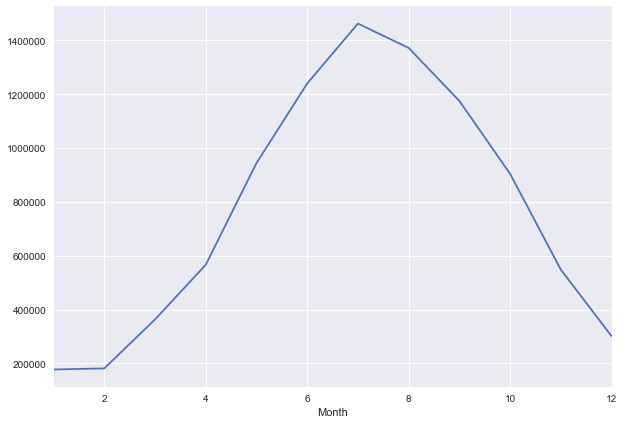

In [5]:
#plot the count of rides per month
pt_month.plot(figsize=(10,7));

### Rides per week

In [6]:
# pivot table of count of rides per week
pt_weekday = df.pivot_table(index="Weekday", values="bikeid", aggfunc="count")

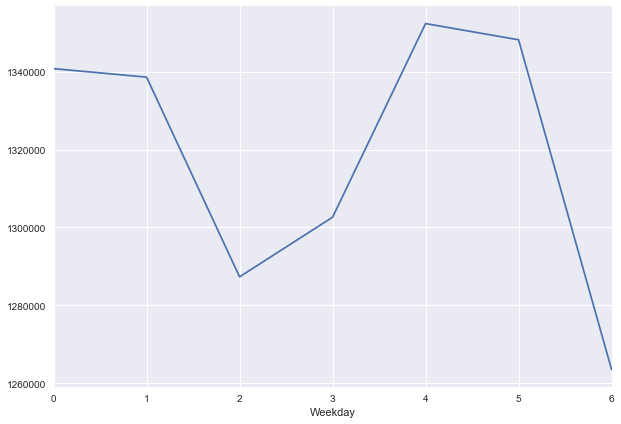

In [7]:
#Monday is 0, Sunday is 6
pt_weekday.plot(figsize=(10,7));

## Autocorrelation

To measure how much the sales are correlated with each other, we want to compute the _autocorrelation_ of the 'Sales' column. In pandas, we do this we with the `autocorr` function.

`autocorr` takes one argument, the `lag` - which is how many prior data points should be used to compute the correlation. If we set the `lag` to 1, we compute the correlation between every point and the point directly preceding it, while setting `lag` to 10, computes the correlation between every point and the point 10 days earlier.

### Daily Autocorrelation

In [8]:
# resample all data to daily counts
R_day = df.trip_id.resample("D").count()
R_day.head(10)

starttime
2014-01-01    123
2014-01-02    112
2014-01-03      6
2014-01-04    205
2014-01-05     33
2014-01-06      1
2014-01-07      0
2014-01-08      0
2014-01-09    860
2014-01-10    823
Freq: D, Name: trip_id, dtype: int64

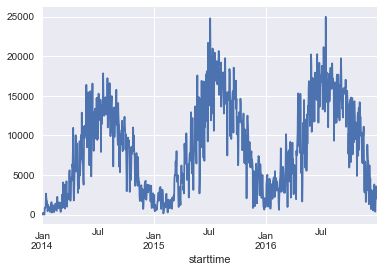

In [9]:
R_day.plot();

In [10]:
# check autocorrelation for previous two weeks
for i in range(1,16):
    print(i, R_day.autocorr(lag=i))

1 0.900932618596
2 0.857101202917
3 0.845233033896
4 0.840985394527
5 0.837716668748
6 0.840212555331
7 0.849030514391
8 0.830915156918
9 0.815358168277
10 0.819126050022
11 0.81522225069
12 0.808773514049
13 0.817084883618
14 0.825879698517
15 0.812129458788


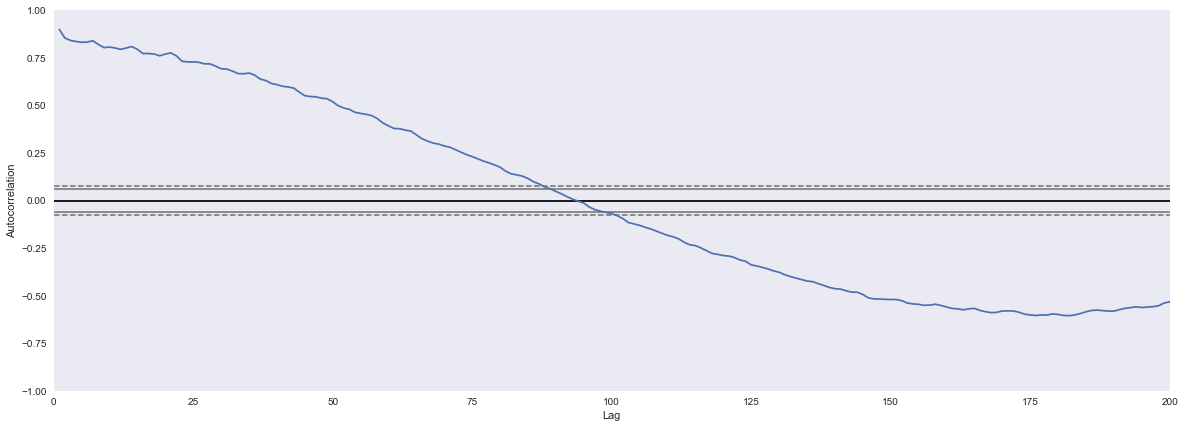

In [11]:
# plot autocorrelation for different lags using pandas
from pandas.tools.plotting import autocorrelation_plot
plt.figure(figsize=(20,7))

autocorrelation_plot(R_day)
plt.xlim(0,200);

#plot shows high autocorrelation accross lags

### Weekly Autocorrelation

In [11]:
# resample all data to daily counts
R_week = df.trip_id.resample("W").count()
R_week.head(10)

starttime
2014-01-05      479
2014-01-12     3509
2014-01-19    10647
2014-01-26     5591
2014-02-02     5493
2014-02-09     5037
2014-02-16     7223
2014-02-23     8395
2014-03-02     7708
2014-03-09     9461
Freq: W-SUN, Name: trip_id, dtype: int64

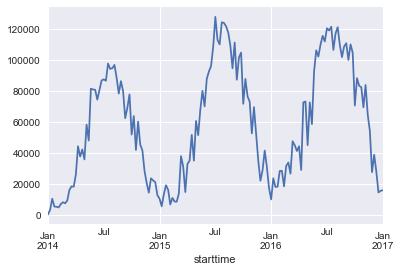

In [12]:
R_week.plot();

In [13]:
# check autocorrelation for previous 6 weeks
for i in range(1,6):
    print(i, R_week.autocorr(lag=i))

1 0.939026079092
2 0.916434755083
3 0.883573580893
4 0.838234613943
5 0.780641496648


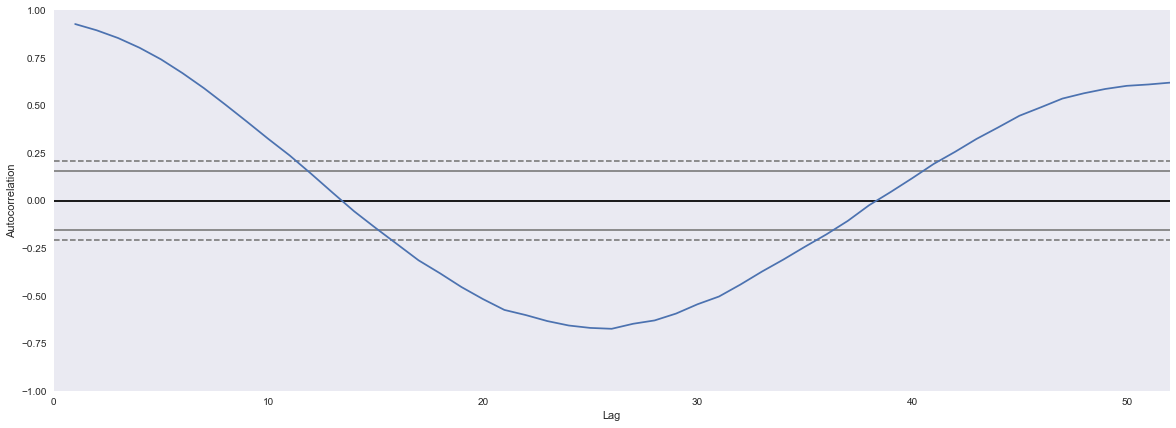

In [14]:
# plot autocorrelation for different lags using pandas
from pandas.tools.plotting import autocorrelation_plot
plt.figure(figsize=(20,7))

autocorrelation_plot(R_week)
plt.xlim(0,52);

#plot shows high autocorrelation accross lags

### Monthly Autocorrelation

In [15]:
# resample all data to daily counts
R_month = df.trip_id.resample("M").count()
R_month.head(10)

starttime
2014-01-31     25076
2014-02-28     28087
2014-03-31     69308
2014-04-30    158476
2014-05-31    278745
2014-06-30    346007
2014-07-31    410340
2014-08-31    392117
2014-09-30    308513
2014-10-31    237313
Freq: M, Name: trip_id, dtype: int64

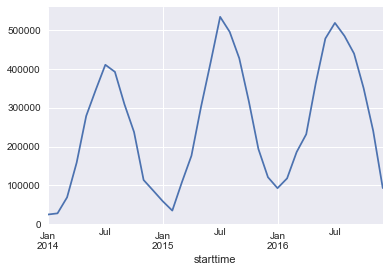

In [16]:
R_month.plot();

In [17]:
# check autocorrelation for previous 6 months
for i in range(1,6):
    print(i, R_month.autocorr(lag=i))

1 0.859030868826
2 0.507274075852
3 0.0367602250829
4 -0.418371009942
5 -0.736462646872


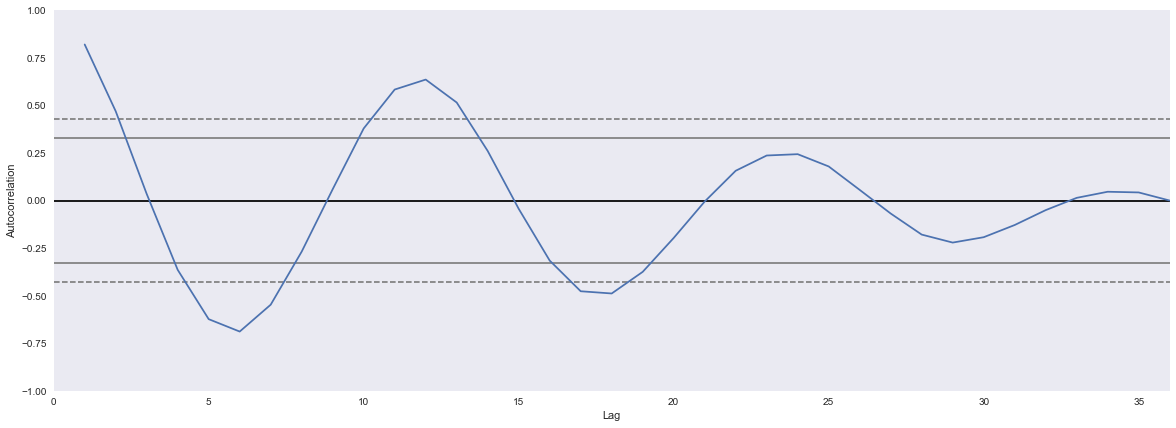

In [18]:
# plot autocorrelation for different lags using pandas
from pandas.tools.plotting import autocorrelation_plot
plt.figure(figsize=(20,7))

autocorrelation_plot(R_month)
plt.xlim(0,36);

#plot shows high autocorrelation accross lags

### Weekly Autocorrelation by user type (member/subscriber)

In [19]:
df.usertype.value_counts()

Subscriber    6653676
Customer      2579597
Dependent         183
Name: usertype, dtype: int64

In [20]:
# resample all data to daily counts
df_usertype = pd.get_dummies(df["usertype"])

In [21]:
df_usertype = df_usertype.drop("Dependent", axis=1)

In [22]:
R_usertype_week = df_usertype.resample("W").sum()

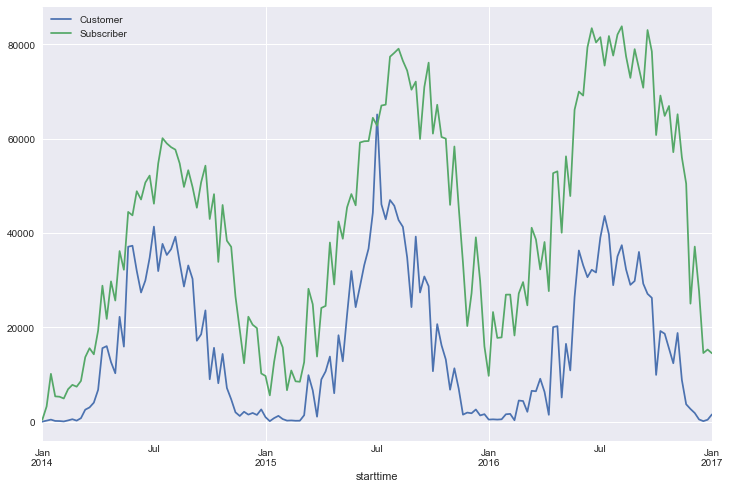

In [23]:
R_usertype_week.plot(figsize=(12,8));

### Monthly Autocorrelation by user type (member/subscriber)

In [24]:
R_usertype_month = df_usertype.resample("M").sum()

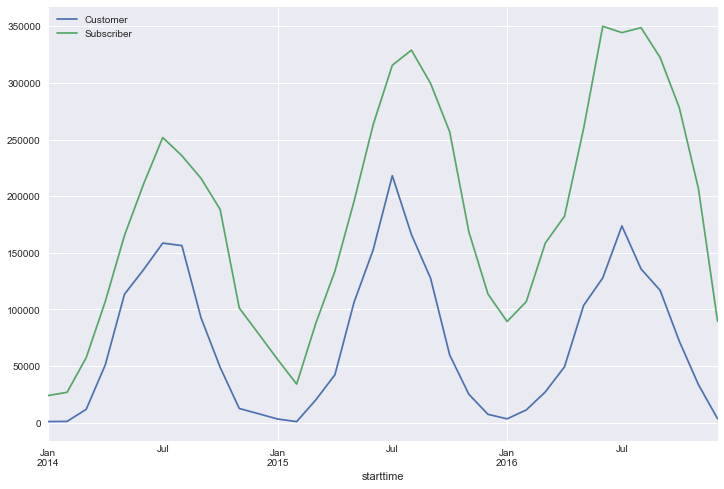

In [25]:
R_usertype_month.plot(figsize=(12,8));

## Moving/Rolling Averages

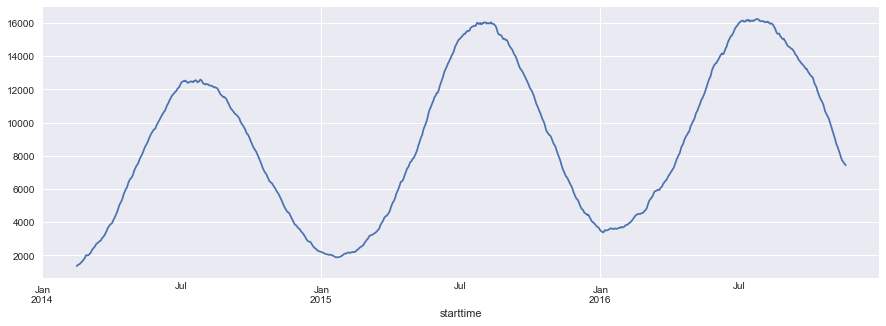

In [26]:
R_day.rolling(window=90, center=True).mean().plot(figsize=(15,5));

## Check Stationarity of Time Series

A time series is stationary is the mean and standard deviation is constant overtime. Most time series models assume the time series is stationary, so it's importat to check so we can account for this later.


**Dickey-Fuller Test:** This is a statistical check to test for stationarity. The null-hypothesis assumes that the time series is not stationary. If the p-value output is below our threshold (0.05) then we can reject the null- hypothesis and assume the time series is stationary. 

In [27]:
from statsmodels.tsa.stattools import adfuller

In [28]:
def test_stationarity(timeseries):
    
    """
    ===============================
    This function tests the stationarity of a timeseries
    ===============================
    Input: time series dataframe or array
    ===============================
    Output: Dickey-Fuller Test and graph ploting rolloing mean and standard deviation
    ===============================
    """
    
    #Perform Dickey-Fuller test:
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

Results of Dickey-Fuller Test:
Test Statistic                   -1.767486
p-value                           0.396719
#Lags Used                       22.000000
Number of Observations Used    1073.000000
Critical Value (1%)              -3.436459
Critical Value (5%)              -2.864237
Critical Value (10%)             -2.568206
dtype: float64


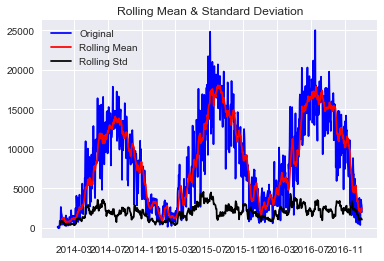

In [29]:
test_stationarity(R_day)

Notes:
Use SARIMA model for trends in seasonality
use ARIMA is season does not affect trends

Results of Dickey-Fuller Test:
Test Statistic                  -5.403089
p-value                          0.000003
#Lags Used                       9.000000
Number of Observations Used    147.000000
Critical Value (1%)             -3.475637
Critical Value (5%)             -2.881410
Critical Value (10%)            -2.577365
dtype: float64


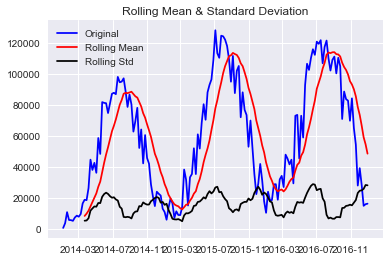

In [30]:
test_stationarity(R_week)

Results of Dickey-Fuller Test:
Test Statistic                -6.311371e+00
p-value                        3.228443e-08
#Lags Used                     2.000000e+00
Number of Observations Used    3.300000e+01
Critical Value (1%)           -3.646135e+00
Critical Value (5%)           -2.954127e+00
Critical Value (10%)          -2.615968e+00
dtype: float64


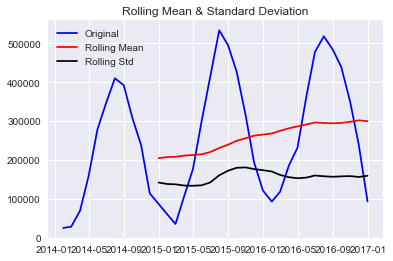

In [31]:
test_stationarity(R_month)

## Remove Stationarity

The Dickey-Fuller test shows that the data is not stationary. There is a clear seasonal trend with a growth in bike usage during the warmer summer months. 

A SARIMA model assumes the data is stationary, so this needs to be removed before we run our model.


The first thing we want to do is take a first difference of the data. This should help to eliminate the overall trend from the data.

Results of Dickey-Fuller Test:
Test Statistic                -8.196985e+00
p-value                        7.403824e-13
#Lags Used                     2.100000e+01
Number of Observations Used    1.073000e+03
Critical Value (1%)           -3.436459e+00
Critical Value (5%)           -2.864237e+00
Critical Value (10%)          -2.568206e+00
dtype: float64


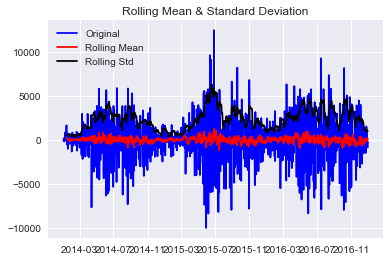

In [32]:
first_difference = R_day - R_day.shift(1)
first_difference
test_stationarity(first_difference.dropna(inplace=False))

Our next step is to take a seasonal difference to remove the seasonality of the data and see how that impacts the stationarity of the data.

Results of Dickey-Fuller Test:
Test Statistic                   -2.574666
p-value                           0.098347
#Lags Used                       22.000000
Number of Observations Used    1043.000000
Critical Value (1%)              -3.436635
Critical Value (5%)              -2.864315
Critical Value (10%)             -2.568248
dtype: float64


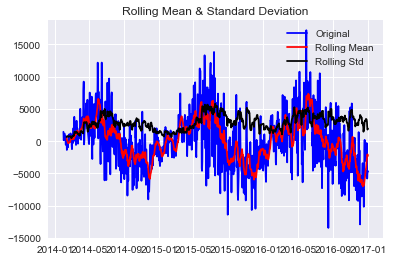

In [33]:
seasonal_difference = R_day - R_day.shift(30)
seasonal_difference
test_stationarity(seasonal_difference.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                  -1.676974
p-value                          0.443014
#Lags Used                       7.000000
Number of Observations Used    148.000000
Critical Value (1%)             -3.475325
Critical Value (5%)             -2.881275
Critical Value (10%)            -2.577293
dtype: float64


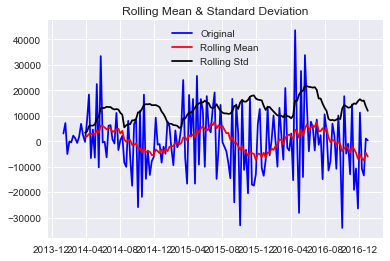

In [34]:
seasonal_difference_week = R_week - R_week.shift(1)
seasonal_difference_week
test_stationarity(seasonal_difference_week.dropna(inplace=False))

## General Seasonal Autoregressive Integrated Moving Average Model (SARIMA)

The parameters of the ARIMA model are defined as follows:

- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

### Initial SARIMA Model for day

Create an initial SARIMA model to show what model looks like without fine tunning

In [38]:
# fit SARIMA on daily counts
# first we look at acf and pacf
import statsmodels.api as sm
sarima0 = sm.tsa.statespace.SARIMAX(R_day, order=(0,0,0), seasonal_order=(0,0,0,0), trend="c").fit()
sarima0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                trip_id   No. Observations:                 1096
Model:                        SARIMAX   Log Likelihood              -11019.554
Date:                Tue, 04 Apr 2017   AIC                          22043.109
Time:                        14:30:30   BIC                          22053.107
Sample:                    01-01-2014   HQIC                         22046.892
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8424.6861    177.446     47.478      0.000    8076.899    8772.473
sigma2      3.167e+07   2.11e+06     14.987      0.000    2.75e+07    3.58e+07
===================================================================================
Ljung-Box (Q):                    25414.38   Jarque-Bera (JB):                69.37
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                             0.27
Prob(H) (two-sided):                  0.02   Kurtosis:                         1.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Figure(432x288)
Figure(432x288)


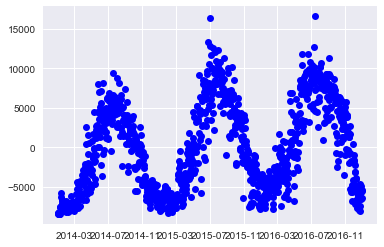

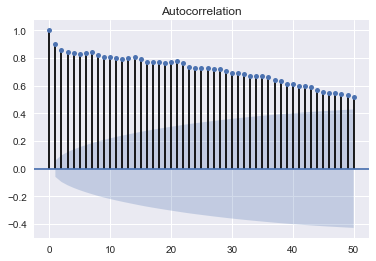

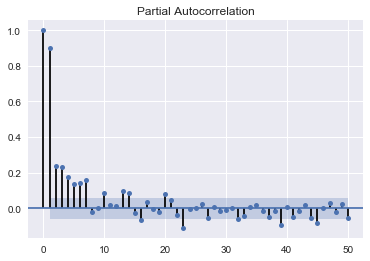

In [39]:
# look at resids to find patterns and update sarima
plt.plot(sarima0.resid, "bo")
print(plot_acf(sarima0.resid, lags=50))
print(plot_pacf(sarima0.resid, lags=50))

### SARIMA With Tuned Parameters for day

In [40]:
# fit better sarima

sarima1 = sm.tsa.statespace.SARIMAX(R_day, order=(1,0,5), seasonal_order=(1,1,1,7), trend='c').fit()
sarima1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                           trip_id   No. Observations:                 1096
Model:             SARIMAX(1, 0, 5)x(1, 1, 1, 7)   Log Likelihood               -9975.158
Date:                           Tue, 04 Apr 2017   AIC                          19970.317
Time:                                   14:30:45   BIC                          20020.247
Sample:                               01-01-2014   HQIC                         19989.215
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2150      2.905     -0.074      0.941      -5.908       5.478
ar.L1          0.9944      0.009    114.480      0.000       0.977       1.011
ma.L1         -0.5247      0.041    -12.766      0.000      -0.605      -0.444
ma.L2         -0.2063      0.051     -4.084      0.000      -0.305      -0.107
ma.L3         -0.0700      0.048     -1.443      0.149      -0.165       0.025
ma.L4         -0.0169      0.049     -0.341      0.733      -0.114       0.080
ma.L5          0.0021      0.045      0.047      0.962      -0.086       0.091
ar.S.L7        0.0176      0.049      0.356      0.722      -0.079       0.114
ma.S.L7       -0.8789      0.028    -31.191      0.000      -0.934      -0.824
sigma2      7.732e+06   3.51e-06    2.2e+12      0.000    7.73e+06    7.73e+06
===================================================================================
Ljung-Box (Q):                       53.58   Jarque-Bera (JB):               282.61
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               1.71   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.13e+28. Standard errors may be unstable.
"""

Figure(432x288)
Figure(432x288)


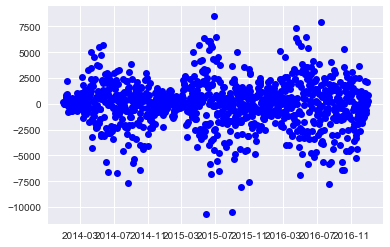

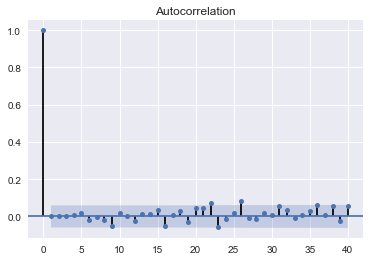

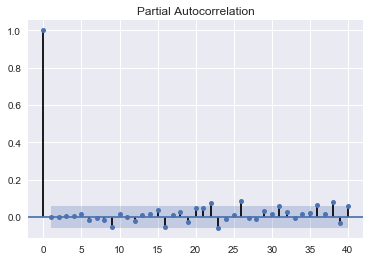

In [41]:
plt.plot(sarima1.resid, "bo")
print(plot_acf(sarima1.resid, lags=40))
print(plot_pacf(sarima1.resid, lags=40))

### SARIMA Model for week

In [42]:
# fit SARIMA on weekly counts
# first we look at acf and pacf
import statsmodels.api as sm
sarima2 = sm.tsa.statespace.SARIMAX(R_week, order=(0,0,0), seasonal_order=(0,0,0,0), trend="c").fit()
sarima2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                trip_id   No. Observations:                  157
Model:                        SARIMAX   Log Likelihood               -1874.554
Date:                Tue, 04 Apr 2017   AIC                           3753.109
Time:                        14:30:46   BIC                           3759.221
Sample:                    01-05-2014   HQIC                          3755.591
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.881e+04   3014.562     19.509      0.000    5.29e+04    6.47e+04
sigma2      1.375e+09   2.69e+08      5.120      0.000    8.49e+08     1.9e+09
===================================================================================
Ljung-Box (Q):                     1859.83   Jarque-Bera (JB):                11.83
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             0.16
Prob(H) (two-sided):                  0.42   Kurtosis:                         1.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Figure(432x288)
Figure(432x288)


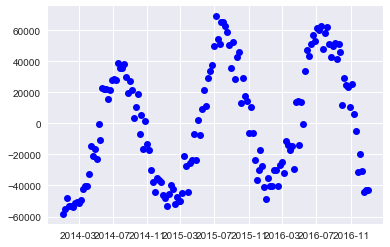

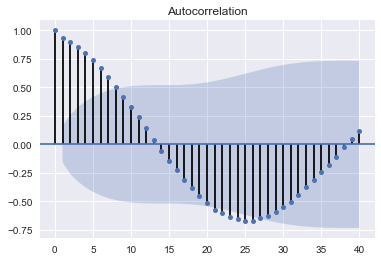

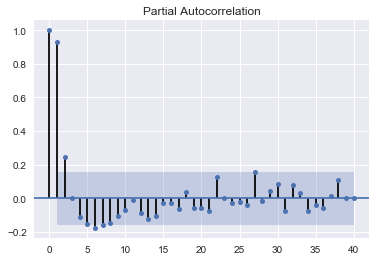

In [43]:
plt.plot(sarima2.resid, "bo")
print(plot_acf(sarima2.resid, lags=40))
print(plot_pacf(sarima2.resid, lags=40))

In [44]:
# fit SARIMA on weekly counts
# first we look at acf and pacf
import statsmodels.api as sm
sarimaw = sm.tsa.statespace.SARIMAX(R_week, order=(1,1,3), seasonal_order=(1,0,0,52), trend=None).fit()
sarimaw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                            trip_id   No. Observations:                  157
Model:             SARIMAX(1, 1, 3)x(1, 0, 0, 52)   Log Likelihood               -1670.516
Date:                            Tue, 04 Apr 2017   AIC                           3353.033
Time:                                    14:30:50   BIC                           3371.332
Sample:                                01-05-2014   HQIC                          3360.465
                                     - 01-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8752      0.093      9.380      0.000       0.692       1.058
ma.L1         -1.4177      0.129    -10.967      0.000      -1.671      -1.164
ma.L2          0.5344      0.166      3.223      0.001       0.209       0.859
ma.L3          0.0745      0.112      0.666      0.505      -0.145       0.293
ar.S.L52       0.3100      0.109      2.855      0.004       0.097       0.523
sigma2      1.404e+08   2.96e-10   4.74e+17      0.000     1.4e+08     1.4e+08
===================================================================================
Ljung-Box (Q):                       29.22   Jarque-Bera (JB):                 0.26
Prob(Q):                              0.90   Prob(JB):                         0.88
Heteroskedasticity (H):               1.94   Skew:                             0.08
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.9e+33. Standard errors may be unstable.
"""

In [45]:
# df_week['forecast'] = sarimaw.predict(start=150, end=175)  
# df_week
# df_week.plot(figsize=(12, 8));

Figure(432x288)
Figure(432x288)


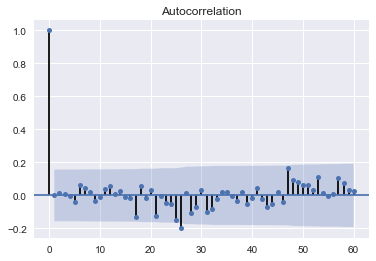

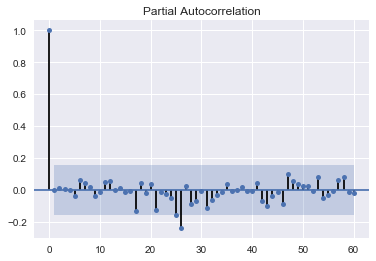

In [46]:
#plt.plot(sarimaw.resid, "bo")
print(plot_acf(sarimaw.resid, lags=60))
print(plot_pacf(sarimaw.resid, lags=60))

### SARIMA Model for month

In [47]:
# fit SARIMA on monthly counts1
# first we look at acf and pacf
sarima_month = sm.tsa.statespace.SARIMAX(
    R_month, order=(0,1,0), seasonal_order=(0,1,0,12), trend=None).fit()

sarima_month.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                            trip_id   No. Observations:                   36
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -273.727
Date:                            Tue, 04 Apr 2017   AIC                            549.455
Time:                                    14:30:51   BIC                            550.590
Sample:                                01-31-2014   HQIC                           549.741
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.356e+08   1.72e+08      4.859      0.000    4.99e+08    1.17e+09
===================================================================================
Ljung-Box (Q):                       20.27   Jarque-Bera (JB):                 0.85
Prob(Q):                              0.57   Prob(JB):                         0.65
Heteroskedasticity (H):               1.61   Skew:                            -0.46
Prob(H) (two-sided):                  0.51   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

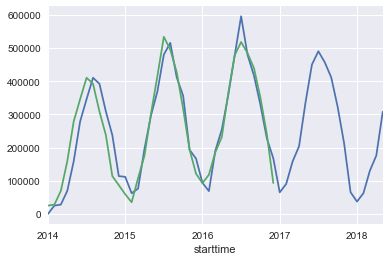

In [48]:
plt.legend()
sarima_month.predict(start=0, end=52, dynamic=48).plot()
R_month.plot()

Figure(432x288)
Figure(432x288)


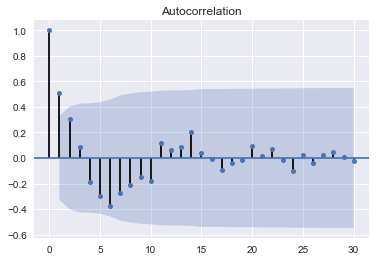

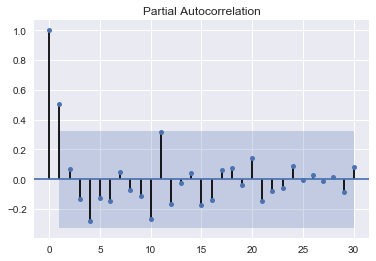

In [49]:
#plt.plot(sarimaw.resid, "bo")
print(plot_acf(sarima_month.resid, lags=30))
print(plot_pacf(sarima_month.resid, lags=30))

## General Forecasting

Make predictions based on daily and weekly SARIMA models

In [50]:
#turn daily series into dataframe and add prediction column
df_day = R_day.to_frame()
df_day.rename(columns= {"trip_id" : "count"}, inplace=True)

#turn weekly series into dataframe and add prediction column
df_week = R_week.to_frame()
df_week.rename(columns= {"trip_id" : "count"}, inplace=True)

#turn weekly series into dataframe and add prediction column
df_month = R_month.to_frame()
df_month.rename(columns= {"trip_id" : "count"}, inplace=True)



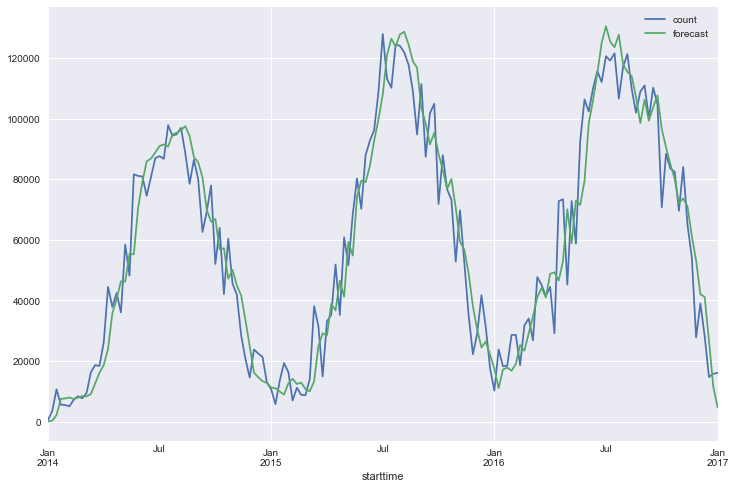

In [51]:
#plot weekly actual and forecast
df_week['forecast'] = sarimaw.predict()  
df_week
df_week.plot(figsize=(12, 8));

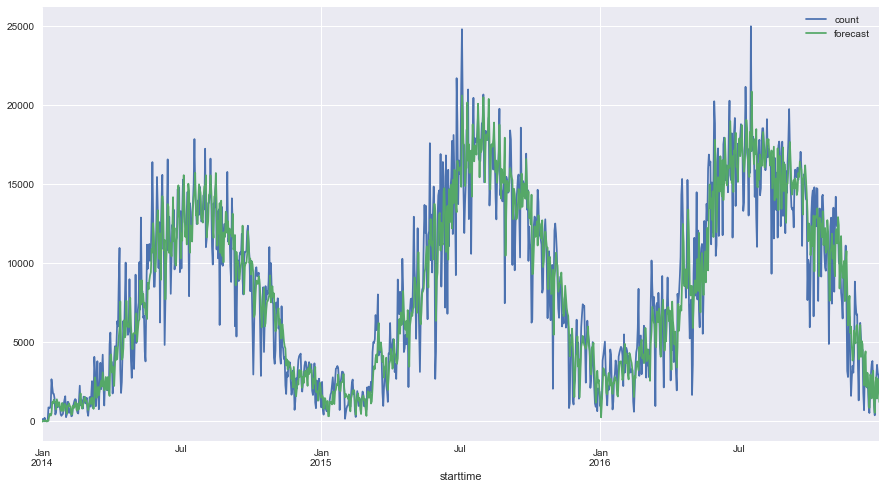

In [52]:
#plot daily actual and forecast
df_day['forecast'] = sarima1.predict()  
df_day
df_day.plot(figsize=(15, 8));

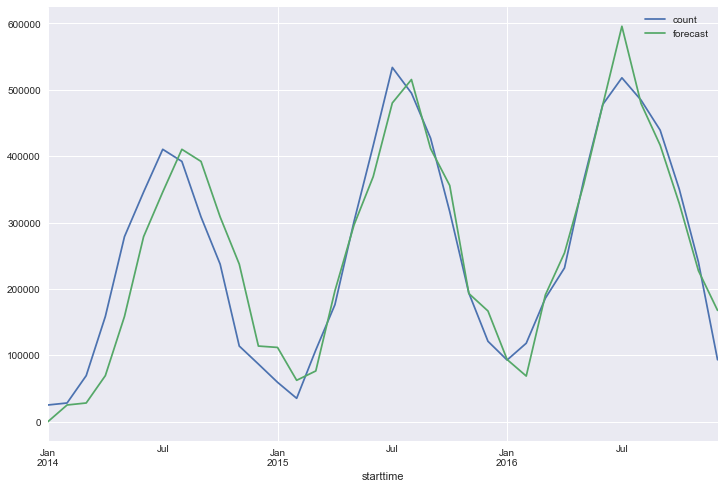

In [53]:
#plot monthly actual and forecast
df_month['forecast'] = sarima_month.predict()  
df_month.plot(figsize=(12, 8));

### Show daily projections into future

Add new time periods into dataframe

In [63]:
#add daily dates to df_day
start = dt.strptime("2017-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(days=x) for x in range(0,365)]
future_day = pd.DataFrame(index=date_list, columns= df_day.columns)
df_day = pd.concat([df_day, future_day])

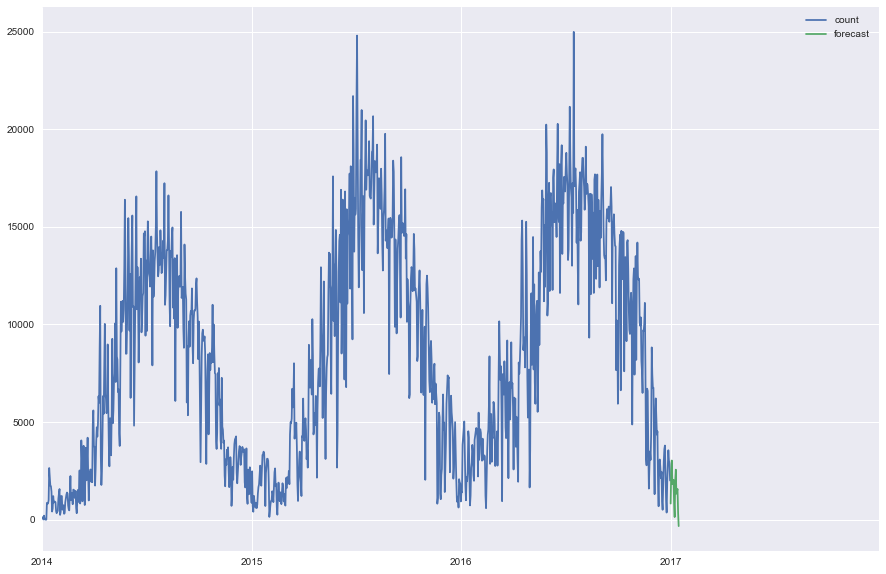

In [81]:
df_day['forecast'] = sarima1.predict(start=1096, end=1110, dynamic=0)  
df_day
df_day.plot(figsize=(15, 10));

In [82]:
#plot the last few days of data and project days into the future
df_day_recent = df_day.ix[1080:1103]

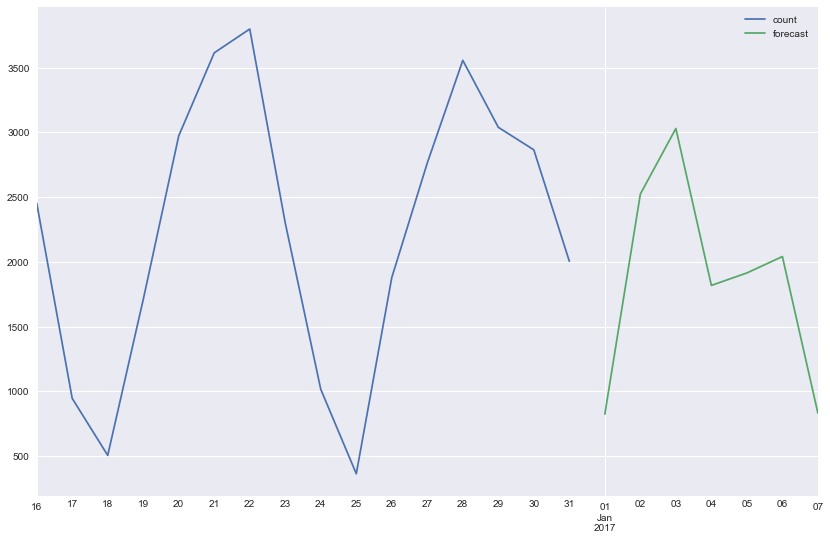

In [83]:
df_day_recent.plot(figsize=(14, 9));

In [67]:
#add weekly dates to df_week
start = dt.strptime("2017-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(weeks=x) for x in range(0,52)]
future_week = pd.DataFrame(index=date_list, columns= df_week.columns)
df_week = pd.concat([df_week, future_week])

In [68]:
df_week.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209 entries, 2014-01-05 to 2017-12-24
Data columns (total 2 columns):
count       157 non-null float64
forecast    157 non-null float64
dtypes: float64(2)
memory usage: 4.9 KB


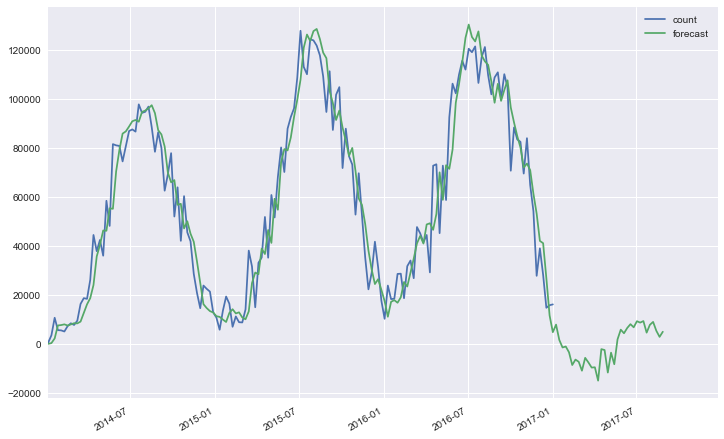

In [69]:
df_week['forecast'] = sarimaw.predict(start=0, end=190, dynamic=157)  
df_week
df_week.plot(figsize=(12, 8));

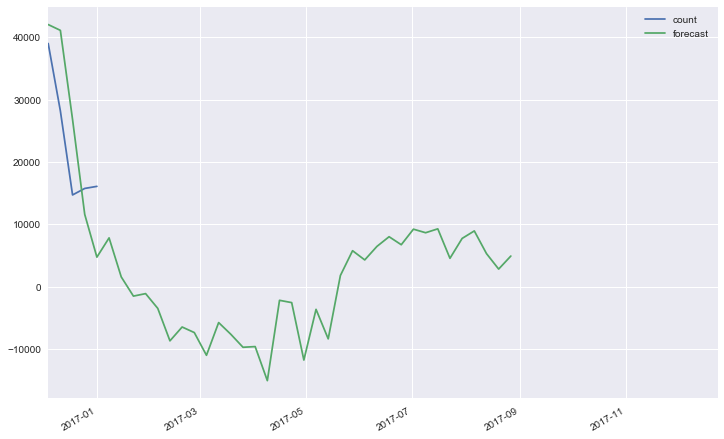

In [70]:
#plot the last few weeks of data and project days into the future
df_week_recent = df_week.ix[152:]
df_week_recent.plot(figsize=(12, 8));

In [71]:
#add monthly dates to df_month
start = dt.strptime("2016-12-31", "%Y-%m-%d")
date_list = [start + relativedelta(month=x) for x in range(0,12)]
future_month = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month = pd.concat([df_month, future_month])

In [72]:
df_month['forecast'] = sarima_month.predict(start=0, end=80)  
#df_month.plot(figsize=(12, 8));

## Subscriber/Customer SARIMA

Create SARIMA Models to predict the number of customers and subscribers expected per month for the next 6 months

### Subscriber SARIMA

In [54]:
# fit SARIMA on monthly subscriber counts
sarima_sub_month = sm.tsa.statespace.SARIMAX(
    R_usertype_month["Subscriber"], order=(1,1,0), seasonal_order=(1,1,0,12), trend="c").fit()

sarima_sub_month.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         Subscriber   No. Observations:                   36
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -264.946
Date:                            Tue, 04 Apr 2017   AIC                            537.891
Time:                                    14:31:52   BIC                            542.433
Sample:                                01-31-2014   HQIC                           539.033
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1366.8307   5557.628     -0.246      0.806   -1.23e+04    9525.920
ar.L1         -0.0979      0.265     -0.370      0.712      -0.617       0.421
ar.S.L12       0.1478      0.213      0.695      0.487      -0.269       0.564
sigma2      6.099e+08      0.069   8.82e+09      0.000     6.1e+08     6.1e+08
===================================================================================
Ljung-Box (Q):                       24.10   Jarque-Bera (JB):                 1.20
Prob(Q):                              0.34   Prob(JB):                         0.55
Heteroskedasticity (H):               2.80   Skew:                            -0.56
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.28e+27. Standard errors may be unstable.
"""

Figure(432x288)
Figure(432x288)


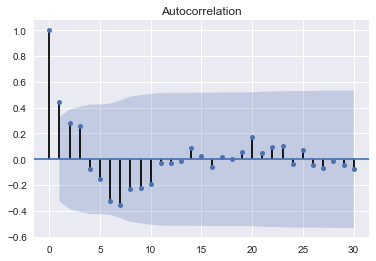

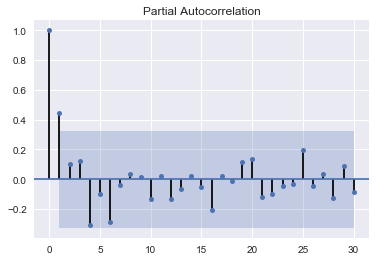

In [55]:
#plt.plot(sarimaw.resid, "bo")
print(plot_acf(sarima_sub_month.resid, lags=30))
print(plot_pacf(sarima_sub_month.resid, lags=30))

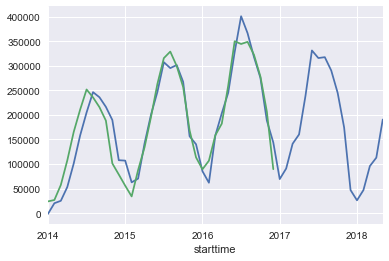

In [56]:
plt.legend()
sarima_sub_month.predict(start=0, end=52, dynamic=48).plot()
R_usertype_month["Subscriber"].plot()

In [57]:
# fit SARIMA on monthly counts1
# first we look at acf and pacf
# sarima_sub_month = sm.tsa.statespace.SARIMAX(
#     R_usertype_month["Subscriber"], order=(1,1,0), seasonal_order=(1,1,0,12), trend="c").fit()

# sarima_sub_month.summary()

### Customer SARIMA

In [58]:
# fit SARIMA on monthly customer counts
sarima_cust_month = sm.tsa.statespace.SARIMAX(
    R_usertype_month["Customer"], order=(0,1,0), seasonal_order=(0,1,0,12), trend="c").fit()

sarima_cust_month.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                           Customer   No. Observations:                   36
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -260.125
Date:                            Tue, 04 Apr 2017   AIC                            524.249
Time:                                    14:31:58   BIC                            526.520
Sample:                                01-31-2014   HQIC                           524.820
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -265.5652   4143.704     -0.064      0.949   -8387.076    7855.946
sigma2        3.9e+08   1.09e+08      3.575      0.000    1.76e+08    6.04e+08
===================================================================================
Ljung-Box (Q):                       12.58   Jarque-Bera (JB):                 0.17
Prob(Q):                              0.94   Prob(JB):                         0.92
Heteroskedasticity (H):               0.38   Skew:                            -0.17
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Figure(432x288)
Figure(432x288)


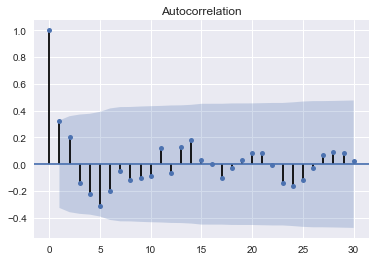

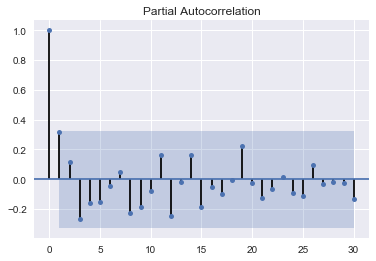

In [59]:
#plt.plot(sarimaw.resid, "bo")
print(plot_acf(sarima_cust_month.resid, lags=30))
print(plot_pacf(sarima_cust_month.resid, lags=30))

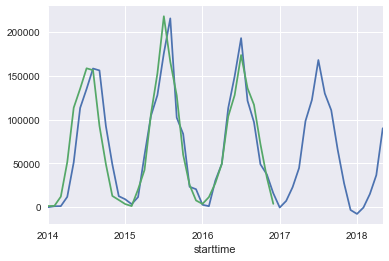

In [60]:
plt.legend()
sarima_cust_month.predict(start=0, end=52, dynamic=48).plot()
R_usertype_month["Customer"].plot()

## Visualizations

Plot time series in plotly: https://plot.ly/python/time-series/

In [61]:
import plotly.plotly as py
import cufflinks as cf
import plotly.graph_objs as go

In [73]:
df_week_recent.iplot(kind='scatter', filename='cf-simple-line')

In [84]:
df_day_recent.iplot(kind='scatter', filename='cf-simple-line')

In [88]:
R_usertype_month["Subscriber"].iplot(kind='line', fill=True,
         yTitle='Bike Count', title='Subscriber and Customer Divvy Bike Share Usage',
         filename='test chart')

# sarima_sub_month.predict(start=0, end=52, dynamic=48).iplot(kind='line', fill=True,
#          yTitle='Bike Count', title='Subscriber and Customer Divvy Bike Share Usage',
#          filename='test chart')

In [94]:
df_month_sub = R_usertype_month["Subscriber"].to_frame()

In [122]:
df_month_sub_predict = sarima_sub_month.predict(start=0, end=41, dynamic=48).to_frame()

In [123]:
df_month_sub_graph = pd.concat([df_month_sub, df_month_sub_predict], axis=1)

In [124]:
df_month_sub_graph.head()

,Subscriber,0
starttime,,
2014-01-31,24016.0,-1460.798367
2014-02-28,26884.0,20305.517133
2014-03-31,57478.0,25237.377462
2014-04-30,107226.0,53120.579870
2014-05-31,165306.0,100996.523563


In [125]:
import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd

trace_high = go.Scatter(
    x=df_month_sub_graph.index,
    y=df_month_sub_graph["Subscriber"],
    name = "Actual",
    line = dict(color = '#17BECF'),
    opacity = 0.8)

trace_low = go.Scatter(
    x=df_month_sub_graph.index,
    y=df_month_sub_graph[0],
    name = "Predicted",
    line = dict(color = '#7F7F7F'),
    opacity = 0.8)

data = [trace_high,trace_low]

layout = dict(
    title='Time Series Forecast for Subscribers',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(),
        type='date'
    )
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "Time Series Forecast for Subscribers")

## Predicting Bike Use Time: Regression

In [217]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import patsy

### Create Dummy Variables

In [139]:
df_2016 = df.ix['2016-01-01':'2016-12-31']

In [232]:
#df_dummy = patsy.dmatrix(data=df, return_type="dataframe", 
#                         formula_like="usertype, Year, birthyear, from_station_name, Month, Week, Weekday")

In [235]:
#df = df["Year","Month","Week","Weekday"].astype(string)

In [140]:
rfr = ske.RandomForestRegressor(n_estimators=10, criterion='mse',
                                n_jobs=-1, random_state=None, verbose=3).fit(df_2016.iloc[4:], df_2016.tripduration)

ValueError: could not convert string to float: 'Male'

### Train test split

In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9233456 entries, 2014-01-01 00:17:00 to 2016-12-31 23:57:00
Data columns (total 16 columns):
trip_id              int64
stoptime             datetime64[ns]
bikeid               int64
tripduration         int64
from_station_id      int64
from_station_name    object
to_station_id        int64
to_station_name      object
usertype             object
gender               object
birthyear            float64
Year                 int64
Month                int64
Week                 int64
Day                  int64
Weekday              int64
dtypes: datetime64[ns](1), float64(1), int64(10), object(4)
memory usage: 1.2+ GB


## Notes

"How to Create an ARIMA Model for Time Series Forecasting with Python": http://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

"A comprehensive beginner’s guide to create a Time Series Forecast (with Codes in Python)": https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

https://plot.ly/ipython-notebooks/cufflinks/

Intro: http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0137922
https://datascopeanalytics.com/blog/design-choices-visualizing-biking-in-chicago/

To Do:
- Monthly SARIMA to show yearly projections for rest of 2017
- Weekly SARIMA to show seasonal projections
- Daily SARIMA model to show monthly projections
- Hourly to show stations projects
- Projections of membership rides vs subscriber?
- Visualization of traffice between stations
- SARIMA weekly, monthly visualization